In [1]:
import os
import numpy as np
import astropy.table as Table
import astropy.units as unit
import astropy.constants as cons
from astropy.io import fits
from astropy.table import Table
import pandas as pd
from astroquery.simbad import Simbad
import astropy.coordinates as coord
from astroquery.gaia import Gaia
import warnings
from pyia import GaiaData
from matplotlib.patches import Ellipse
#import mpld3
from astropy.coordinates import (ICRS, GalacticLSR, CartesianDifferential, CartesianRepresentation)
import stilism_extinction as stil
from scipy import optimize

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(2*3.35,2*.75*3.35)
#plt.rcParams['figure.dpi']=100
#import seaborn as sns
#sns.set_context('paper')
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams['figure.figsize']=(9,6)
# plt.rcParams['font.size']=20
# plt.rcParams['font.family']='serif'
#%matplotlib notebook
#plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
#from cycler import cycler
#plt.rcParams['axes.prop_cycle'] = cycler(color=['#000000','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7'])
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']='True'
plt.rcParams['ytick.minor.visible']='True'

/home/jacobhhamer/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1003: UserWarning: Duplicate key in file "/home/jacobhhamer/.config/matplotlib/matplotlibrc", line #78
  (fname, cnt))
/home/jacobhhamer/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
def outlier_low(series, positive_definite=True):
    if positive_definite:
        mini=series.mean()-3*series.std()
        if mini<0:
            return 0
        else:
            return mini
    else: 
        return mini
def outlier_high(series):
    return series.mean()+3*series.std()

In [3]:
from scipy.interpolate import UnivariateSpline

In [4]:
def extinction_correct_Gaia(data):
    data['ext_B_V'] = np.ones(len(data))*np.nan
    for i, sys in data.iterrows():
        data.loc[i, 'ext_B_V'] = stil.ext_calc(sys.l, sys.b, sys.distance, 100) 
    data['ext_bp_rp'] = (3.374-2.035)*data['ext_B_V'] # Casagrande & VandenBerg 2018 Table 2 
    data['ext_G'] = 2.740*data['ext_B_V'] # Casagrande & VandenBerg 2018 Table 2 
    data['bp_rp0'] = data['bp_rp']-data['ext_bp_rp']
    data['G0'] = data['phot_g_mean_mag']-data['ext_G']
    data['M_G0'] = data['phot_g_mean_mag']+5-5*np.log10(data['distance'])

In [5]:
plei=pd.read_table('../Data/pleiades.txt', names=['Source', 'Cluster', 'Gmag', 'plx'],dtype={'Source':'long'},skiprows=44, skipfooter=2, delimiter='\s+')
ids=str(tuple(plei.Source.values))

/home/jacobhhamer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.
/home/jacobhhamer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [6]:
plei.shape

(1326, 4)

In [7]:
query='SELECT gaia.designation, gaia.ra, gaia.ra_error, gaia.dec, gaia.dec_error, gaia.parallax, gaia.parallax_error, gaia.parallax_over_error, gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.ra_dec_corr, gaia.ra_parallax_corr, gaia.ra_pmra_corr, gaia.ra_pmdec_corr, gaia.dec_parallax_corr, gaia.dec_pmra_corr, gaia.dec_pmdec_corr, gaia.parallax_pmra_corr, gaia.parallax_pmdec_corr, gaia.pmra_pmdec_corr, gaia.astrometric_n_obs_al, gaia.astrometric_n_obs_ac, gaia.astrometric_n_good_obs_al, gaia.astrometric_n_bad_obs_al, gaia.astrometric_gof_al, gaia.astrometric_chi2_al, gaia.astrometric_excess_noise, gaia.astrometric_excess_noise_sig, gaia.visibility_periods_used, gaia.phot_g_mean_mag, gaia.bp_rp, gaia.bp_g, gaia.g_rp, gaia.radial_velocity, gaia.radial_velocity_error, gaia.phot_variable_flag, gaia.lum_val, gaia.l, gaia.b, gaia.teff_val, bjones.r_est as "distance", bjones.r_lo, bjones.r_hi, gaia.phot_bp_mean_flux_over_error '+\
'FROM gaiadr2.gaia_source as gaia '+\
'INNER JOIN external.gaiadr2_geometric_distance as bjones on gaia.source_id=bjones.source_id '+\
'WHERE gaia.parallax_over_error>10 AND gaia.pmra IS NOT NULL AND gaia.pmdec IS NOT NULL '+\
'AND gaia.phot_bp_mean_flux_over_error>10 AND gaia.phot_rp_mean_flux_over_error>10 '+\
'AND SQRT(gaia.astrometric_chi2_al/(gaia.astrometric_n_good_obs_al-5)) < 1.2*GREATEST(1,EXP(-0.2*(gaia.phot_g_mean_mag-19.5))) '+\
'AND gaia.phot_bp_rp_excess_factor BETWEEN 1.0 + 0.015*POWER(gaia.bp_rp,2) AND 1.3 + 0.06*POWER(gaia.bp_rp,2) '+\
'AND gaia.source_id IN '+ids
job=Gaia.launch_job(query)
job.get_data().write('../Data/Pleiades_GaiaDR2.csv')

In [8]:
pleiades=pd.read_csv('../Data/Pleiades_GaiaDR2.csv')
pleiades['source_id']=pleiades.designation.apply(lambda row: row.lstrip("b'").rstrip("''")).apply(lambda row: row.replace('Gaia DR2 ','')).astype('long')
pleiades=pd.merge(plei,pleiades, left_on='Source',right_on='source_id')
pleiades['ext_B_V']=0.045
pleiades['ext_bp_rp'] = (3.374-2.035)*pleiades['ext_B_V'] # Casagrande & VandenBerg 2018 Table 2 
pleiades['ext_G'] = 2.740*pleiades['ext_B_V'] # Casagrande & VandenBerg 2018 Table 2 
pleiades['bp_rp0'] = pleiades['bp_rp']-pleiades['ext_bp_rp']
pleiades['G0'] = pleiades['phot_g_mean_mag']-pleiades['ext_G']
pleiades['M_G0'] = pleiades['G0']+5-5*np.log10(pleiades['distance'])
pleiades['M_G'] = pleiades['phot_g_mean_mag']+5-5*np.log10(pleiades['distance'])

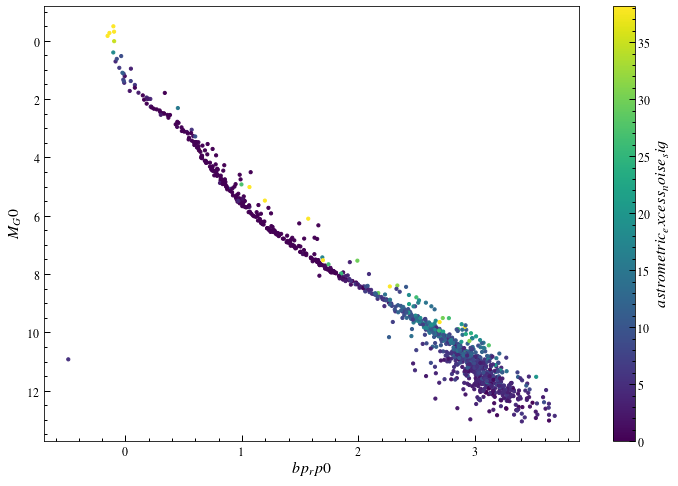

In [9]:
x='bp_rp0'
#y='phot_g_mean_mag'
y='M_G0'
cx='astrometric_excess_noise_sig'
f,ax=plt.subplots(1, figsize=(12,8))
cax=plt.scatter(pleiades[x], pleiades[y], s=10,c=pleiades[cx], vmin=outlier_low(pleiades[cx]), vmax=outlier_high(pleiades[cx]))
#cax=plt.scatter(pleiades[x], pleiades[y], s=10,c=pleiades[cx],vmax=100)
plt.colorbar(mappable=cax,label='$'+cx+'$')
#plt.ylim(9,4)
#plt.xlim(0.5,2.5)
plt.xlabel('$'+x+'$')
plt.ylabel('$'+y+'$')
ax.invert_yaxis()

In [10]:
pleiades.loc[((pleiades.bp_rp0<0)&(pleiades.M_G0>10)),'Source']

980    66697547870378368
Name: Source, dtype: int64

In [11]:
pleiades=pleiades.loc[~(pleiades.Source==66697547870378368)] #REMOVE WHITE DWARF

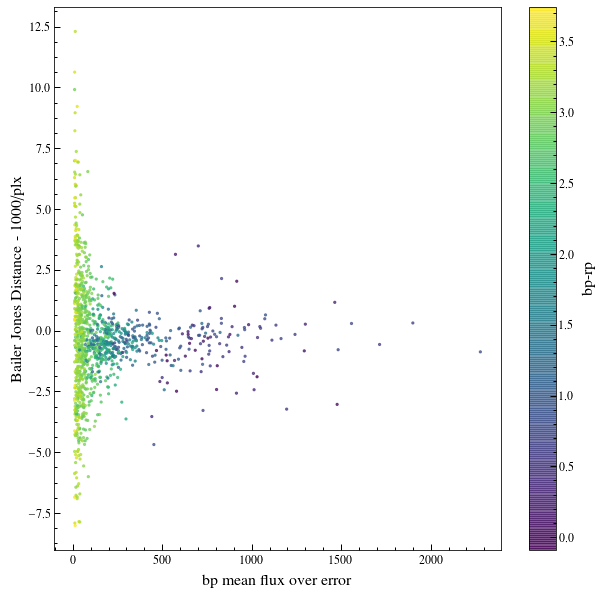

In [12]:
f,ax=plt.subplots(1,1,figsize=(10,10))
cax=plt.scatter(pleiades.phot_bp_mean_flux_over_error,pleiades.distance-1000./pleiades.plx, c=pleiades.bp_rp,s=5, alpha=0.7)
plt.xlabel('bp mean flux over error')
plt.ylabel('Bailer Jones Distance - 1000/plx')
plt.colorbar(mappable=cax, label='bp-rp')

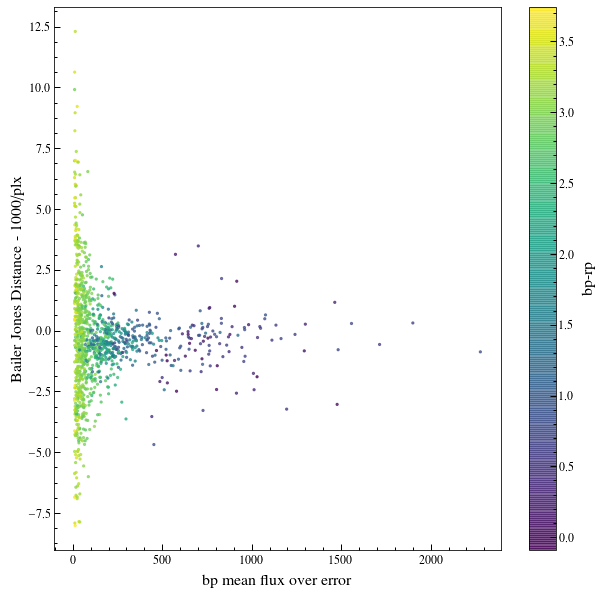

In [13]:
f,ax=plt.subplots(1,1,figsize=(10,10))
cax=plt.scatter(pleiades.phot_bp_mean_flux_over_error,pleiades.distance-1000./pleiades.plx, c=pleiades.bp_rp,s=5, alpha=0.7)
plt.xlabel('bp mean flux over error')
plt.ylabel('Bailer Jones Distance - 1000/plx')
plt.colorbar(mappable=cax, label='bp-rp')

Text(0.5, 0, 'Bailer Jones Distance')

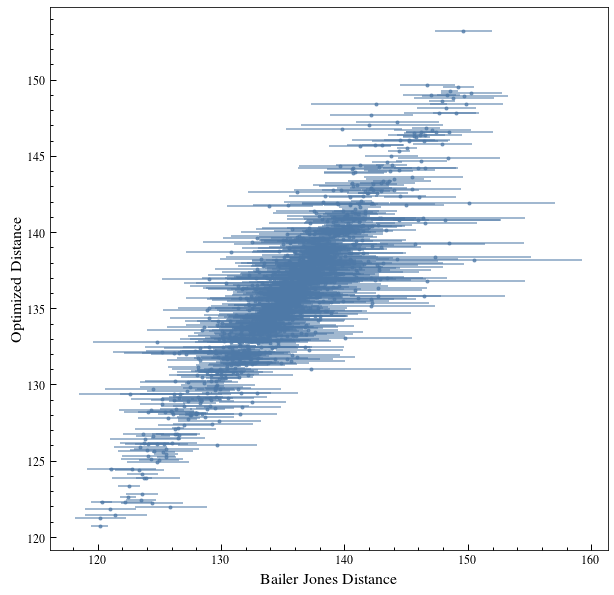

In [14]:
f,ax=plt.subplots(1,1,figsize=(10,10))
plt.errorbar(x=pleiades.distance,y=1000./pleiades.plx,xerr=(pleiades.distance-pleiades.r_lo, pleiades.r_hi-pleiades.distance), alpha=0.7, fmt='.')
plt.ylabel('Optimized Distance')
plt.xlabel('Bailer Jones Distance')
#plt.colorbar(mappable=cax, label='bp-rp')

In [15]:
#splplei=UnivariateSpline(pleiades.sort_values(by='bp_rp',ascending=True).bp_rp, pleiades.sort_values(by='bp_rp',ascending=True).phot_g_mean_mag)
splplei=UnivariateSpline(pleiades.sort_values(by='bp_rp0',ascending=True).bp_rp0, pleiades.sort_values(by='bp_rp0',ascending=True).M_G0)
splplei_un=UnivariateSpline(pleiades.sort_values(by='bp_rp',ascending=True).bp_rp, pleiades.sort_values(by='bp_rp',ascending=True).M_G)

In [16]:
splplei.set_smoothing_factor(160)
splplei_un.set_smoothing_factor(160)

NameError: name 'polys' is not defined

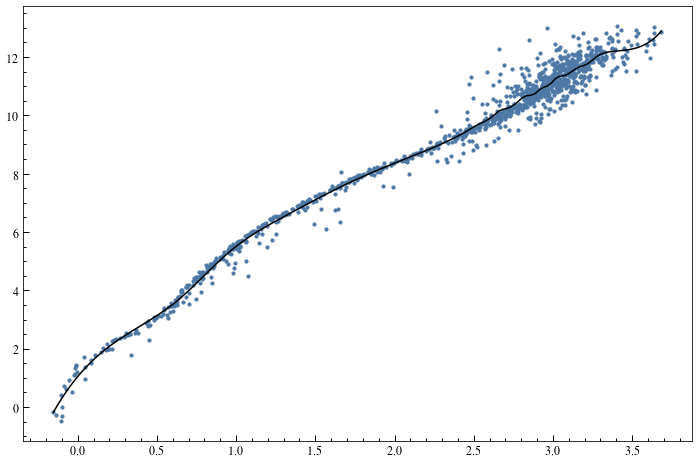

In [17]:
f,ax=plt.subplots(1,figsize=(12,8))
bprps=np.linspace(pleiades.bp_rp0.min(), pleiades.bp_rp0.max(),150)
bprps_un=np.linspace(pleiades.bp_rp.min(), pleiades.bp_rp.max(),150)
#plt.scatter(pleiades.bp_rp, pleiades.phot_g_mean_mag,s=10)
plt.scatter(pleiades.bp_rp0, pleiades.M_G0,s=10)
plt.plot(bprps, splplei(bprps),c='k')
plt.plot(bprps, polys,c='g')
#plt.plot(bprps_un, splplei_un(bprps_un),c='g')
#plt.ylim(9,4)
#plt.xlabel(x)
#plt.ylabel(y)
ax.invert_yaxis()

In [ ]:
x='bp_rp0'
y='M_G0'
cx='phot_g_mean_mag'
f,ax=plt.subplots(1, figsize=(12,8))
cax=plt.scatter(pleiades[x], pleiades[y], s=10,c=pleiades[cx])
plt.colorbar(mappable=cax)#,label=cx)
#plt.ylim(9,4)
plt.xlim(0.5,2.5)
#plt.xlabel(x)
#plt.ylabel(y)

In [20]:
splplei.get_coeffs()

array([-0.1745295 ,  2.3230733 ,  2.54252414,  5.54631992,  6.59988118,
        7.76297267,  8.59023705,  9.17519988,  9.65855025,  9.77533754,
        9.90392849, 10.05051825, 10.13809934, 10.19273253, 10.21350097,
       10.24293815, 10.38722777, 10.6498557 , 10.67855244, 10.68741252,
       10.71899853, 10.92565851, 10.97186376, 11.00763527, 11.08921082,
       11.27865818, 11.34078682, 11.34813415, 11.35886986, 11.42840745,
       11.55213609, 11.6855607 , 11.71061756, 12.12229352, 12.26016258,
       12.22448534, 12.8920296 ])

In [21]:
splplei.get_knots()

array([-0.1533484 ,  0.63099294,  0.96258741,  1.30771737,  1.71082406,
        2.1444674 ,  2.4671927 ,  2.5106812 ,  2.57087331,  2.61055761,
        2.64182287,  2.65866666,  2.66738897,  2.69233232,  2.70922952,
        2.77087217,  2.82155137,  2.84336095,  2.8537417 ,  2.89164453,
        2.919838  ,  2.95142656,  2.96471505,  2.98843198,  3.01530652,
        3.04317003,  3.05686288,  3.07316022,  3.10154062,  3.12891012,
        3.16318994,  3.21736532,  3.27362256,  3.3727818 ,  3.68525129])

In [22]:
tcks=splplei._eval_args

In [23]:
tcks

(array([-0.1533484 , -0.1533484 , -0.1533484 , -0.1533484 ,  0.63099294,
         0.96258741,  1.30771737,  1.71082406,  2.1444674 ,  2.4671927 ,
         2.5106812 ,  2.57087331,  2.61055761,  2.64182287,  2.65866666,
         2.66738897,  2.69233232,  2.70922952,  2.77087217,  2.82155137,
         2.84336095,  2.8537417 ,  2.89164453,  2.919838  ,  2.95142656,
         2.96471505,  2.98843198,  3.01530652,  3.04317003,  3.05686288,
         3.07316022,  3.10154062,  3.12891012,  3.16318994,  3.21736532,
         3.27362256,  3.3727818 ,  3.68525129,  3.68525129,  3.68525129,
         3.68525129]),
 array([-0.1745295 ,  2.3230733 ,  2.54252414,  5.54631992,  6.59988118,
         7.76297267,  8.59023705,  9.17519988,  9.65855025,  9.77533754,
         9.90392849, 10.05051825, 10.13809934, 10.19273253, 10.21350097,
        10.24293815, 10.38722777, 10.6498557 , 10.67855244, 10.68741252,
        10.71899853, 10.92565851, 10.97186376, 11.00763527, 11.08921082,
        11.27865818, 11.3407

In [24]:
tcks

(array([-0.1533484 , -0.1533484 , -0.1533484 , -0.1533484 ,  0.63099294,
         0.96258741,  1.30771737,  1.71082406,  2.1444674 ,  2.4671927 ,
         2.5106812 ,  2.57087331,  2.61055761,  2.64182287,  2.65866666,
         2.66738897,  2.69233232,  2.70922952,  2.77087217,  2.82155137,
         2.84336095,  2.8537417 ,  2.89164453,  2.919838  ,  2.95142656,
         2.96471505,  2.98843198,  3.01530652,  3.04317003,  3.05686288,
         3.07316022,  3.10154062,  3.12891012,  3.16318994,  3.21736532,
         3.27362256,  3.3727818 ,  3.68525129,  3.68525129,  3.68525129,
         3.68525129]),
 array([-0.1745295 ,  2.3230733 ,  2.54252414,  5.54631992,  6.59988118,
         7.76297267,  8.59023705,  9.17519988,  9.65855025,  9.77533754,
         9.90392849, 10.05051825, 10.13809934, 10.19273253, 10.21350097,
        10.24293815, 10.38722777, 10.6498557 , 10.67855244, 10.68741252,
        10.71899853, 10.92565851, 10.97186376, 11.00763527, 11.08921082,
        11.27865818, 11.3407

In [25]:
spl2=UnivariateSpline._from_tck(tcks)

In [26]:
spl2

In [27]:
bprps, splplei(bprps)

(array([-1.53348395e-01, -1.27585981e-01, -1.01823567e-01, -7.60611533e-02,
        -5.02987393e-02, -2.45363254e-02,  1.22608860e-03,  2.69885026e-02,
         5.27509165e-02,  7.85133305e-02,  1.04275744e-01,  1.30038158e-01,
         1.55800572e-01,  1.81562986e-01,  2.07325400e-01,  2.33087814e-01,
         2.58850228e-01,  2.84612642e-01,  3.10375056e-01,  3.36137470e-01,
         3.61899884e-01,  3.87662298e-01,  4.13424712e-01,  4.39187126e-01,
         4.64949540e-01,  4.90711954e-01,  5.16474368e-01,  5.42236782e-01,
         5.67999196e-01,  5.93761610e-01,  6.19524024e-01,  6.45286438e-01,
         6.71048852e-01,  6.96811266e-01,  7.22573680e-01,  7.48336094e-01,
         7.74098508e-01,  7.99860922e-01,  8.25623336e-01,  8.51385750e-01,
         8.77148164e-01,  9.02910578e-01,  9.28672992e-01,  9.54435406e-01,
         9.80197820e-01,  1.00596023e+00,  1.03172265e+00,  1.05748506e+00,
         1.08324748e+00,  1.10900989e+00,  1.13477230e+00,  1.16053472e+00,
         1.1

In [28]:
coeffs=np.polyfit(bprps, splplei(bprps),deg=8)

In [29]:
coeffs

array([-1.70558432e-02,  3.30039604e-01, -2.52542561e+00,  9.78664766e+00,
       -2.02787873e+01,  2.16556140e+01, -1.08594449e+01,  6.23257746e+00,
        1.07857210e+00])

In [32]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

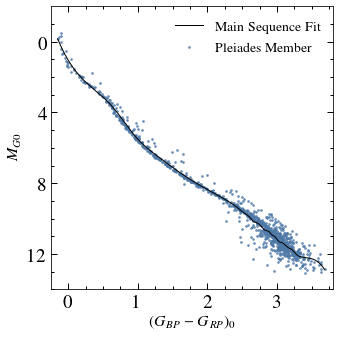

In [41]:
font={'size':16}
plt.rc('font',**font)
f,ax=plt.subplots(figsize=(5,5))
polys=np.polyval(coeffs,bprps)
#plt.plot(bprps, polys, c='k',alpha=1, lw=1, label='Main Sequence Fit')
plt.plot(bprps, splplei(bprps),c='k',lw=1, label='Main Sequence Fit')
plt.scatter(pleiades.bp_rp0, pleiades.M_G0,s=3,alpha=0.7,label='Pleiades Member')
ax.invert_yaxis()
plt.xlabel('$(G_{BP}-G_{RP})_0$')#, fontsize=24)
plt.ylabel('$M_{G0}$')#, fontsize=24)
plt.xlim(-0.25,3.8)
plt.ylim(14,-2)
ax.set_xticks([0,1,2,3])
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.tick_params(top=True, left=True, right=True, bottom=True, which='both')
ax.yaxis.set_major_locator(MultipleLocator(4))
plt.legend(fontsize=14, frameon=False)
plt.tight_layout()
plt.savefig('PaperPlots/Main_sequence_pleiades.png', pad_inches=0)
plt.savefig('PaperPlots/Main_sequence_pleiades.pdf', pad_inches=0)

In [36]:
for c in coeffs[::-1]:
    print(c,', ')

1.078572096698925 , 
6.232577463309115 , 
-10.859444910144996 , 
21.655613965583466 , 
-20.27878733895399 , 
9.786647656946755 , 
-2.5254256142302296 , 
0.33003960356664136 , 
-0.017055843233087616 , 


In [43]:
bprps[np.argmax((np.polyval(coeffs,bprps)-splplei(bprps)))], np.max((np.polyval(coeffs,bprps)-splplei(bprps)))

(3.5306768027880366, 0.10829130765892536)

In [35]:
pleiades.plx.mean()

7.363189565217402

In [36]:
1000/pleiades.plx.mean()

135.810709631034

In [37]:
np.mean(1000/pleiades.plx)

135.96132364111668

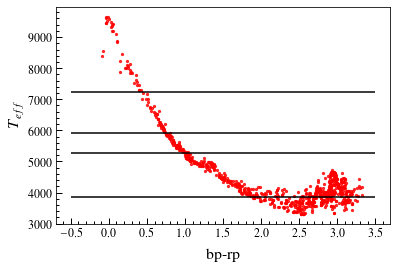

In [38]:
#f,ax=plt.subplots(1,figsize=(9,6))
%matplotlib inline
polys=np.polyval(coeffs,bprps)
plt.scatter(pleiades.bp_rp, pleiades.teff_val, c='r',alpha=0.8, s=5)
plt.xlabel('bp-rp')
plt.ylabel('$T_{eff}$')
plt.hlines([7220,5920,5280,3870],-.5,3.5)